## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2024-08-14 13:15:58.477 | INFO     |  Running on cuda:0


In [3]:
task = 'SlideBlockToTarget'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2024-08-14 13:15:59.381 | INFO     |  Loading dataset(s): 
2024-08-14 13:15:59.382 | INFO     |    Initializing datasete using /home/hartzj/VinDihsl/MT-GMM/data/SlideBlockToTarget/demos/metadata.json
2024-08-14 13:15:59.387 | INFO     |    Extracted gt object labels [81, 83]
2024-08-14 13:15:59.387 | INFO     |    Extracted tsdf object labels []
2024-08-14 13:15:59.387 | INFO     |    Done! Data contains 5 trajectories.


In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'base',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)

n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)

2024-08-14 13:16:03.064 | INFO     |  Subsampling to length 102 using strategy mean-length.


In [6]:
tpgmm_config = TPGMMConfig(
    n_components=30,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,

    add_gripper_action=True,

    reg_shrink=1e-2,
    reg_diag=1e-4,
    reg_diag_gripper=2e-2,

    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=1e-4,
    reg_em_finish_diag_gripper=2e-2,

    em_steps=1,

    trans_cov_mask_t_pos_corr = True,

    fix_first_component=True,
    fix_last_component=True,

    reg_init_diag=1e-4,  # 5

    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.49,
    use_bic=False,

    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,
    repeat_first_step=0,

    components_prop_to_len=True,

    min_n_components=4,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)


In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2024-08-14 13:16:03.143 | INFO     |  Fitting AutoTPGMM
2024-08-14 13:16:03.143 | INFO     |  Performing fitting actions: [INIT]
2024-08-14 13:16:03.143 | INFO     |  Segmenting trajectories


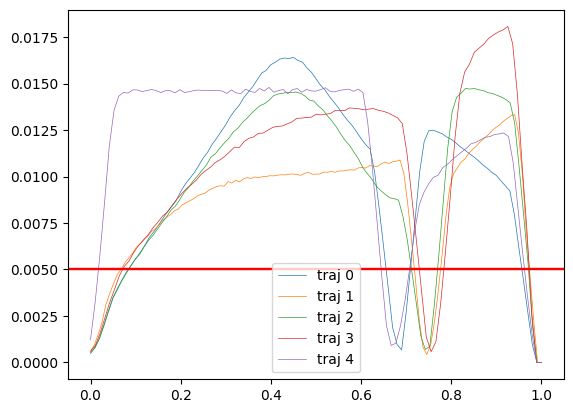

2024-08-14 13:16:03.262 | INFO     |  Creating segement of demos.
2024-08-14 13:16:03.263 | INFO     |  Subsampling to length 73 using strategy mean-length.
2024-08-14 13:16:03.264 | INFO     |  Creating segement of demos.
2024-08-14 13:16:03.265 | INFO     |  Subsampling to length 29 using strategy mean-length.
2024-08-14 13:16:03.266 | INFO     |  ... created 2 segments
2024-08-14 13:16:03.266 | INFO     |    Fitting candidate frame 1/2
2024-08-14 13:16:03.266 | INFO     |    Creating partial frame view of demos.
2024-08-14 13:16:03.268 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2024-08-14 13:16:03.268 | INFO     |    Changing number of components to 21
2024-08-14 13:16:03.268 | INFO     |    Model init ...


Time-based init:   0%|          | 0/21 [00:00<?, ?it/s]

2024-08-14 13:16:03.697 | INFO     |    Fitting candidate frame 2/2
2024-08-14 13:16:03.698 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/21 [00:00<?, ?it/s]

2024-08-14 13:16:04.180 | INFO     |  ee_init    score (rel):     -1 (1.000)
2024-08-14 13:16:04.180 | INFO     |  obj000     score (rel):     -1 (1.000)
2024-08-14 13:16:04.181 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:16:04.182 | INFO     |    Fitting candidate frame 1/2
2024-08-14 13:16:04.182 | INFO     |    Creating partial frame view of demos.
2024-08-14 13:16:04.186 | INFO     |    Changing number of components to 8


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2024-08-14 13:16:04.366 | INFO     |    Fitting candidate frame 2/2
2024-08-14 13:16:04.367 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2024-08-14 13:16:04.502 | INFO     |  ee_init    score (rel):     -0 (0.000)
2024-08-14 13:16:04.503 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:16:04.504 | INFO     |  Segmented trajs into 2 segments
2024-08-14 13:16:04.506 | INFO     |  Frame score (abs):
                ee_init  obj000
Segment 0 -1.000000e+00    -1.0
Segment 1 -6.719121e-07    -1.0
2024-08-14 13:16:04.507 | INFO     |  Frame score (rel):
                ee_init  obj000
Segment 0  1.000000e+00     1.0
Segment 1  6.719121e-07     1.0


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-14 13:16:04.526 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/21 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

((array([[2.62e+16, 2.63e+16, 1.18e+16, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [8.06e+14, 3.59e+15, 9.90e+15, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [4.54e+08, 2.45e+10, 7.75e+11, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.62e+08, 1.12e+06, 1.26e+04],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 6.94e+14, 7.49e+12, 9.60e+10],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.10e+16, 2.93e+16, 1.27e+16]]),
  array([[9.82e+009, 1.03e+010, 4.53e+009, ..., 1.00e-270, 2.13e-282,
          1.21e-292],
         [2.59e+010, 1.08e+011, 2.66e+011, ..., 2.55e-104, 4.96e-108,
          5.93e-111],
         [7.10e+005, 2.00e+007, 2.94e+008, ..., 2.43e-033, 3.46e-036,
          5.09e-039],
         ...,
         [1.17e-030, 1.28e-027, 9.01e-025, ..., 5.85e+006, 3.63e+005,
          1.38e+004],
         [1.08e-047, 5.47e-046, 2.52e-044, ..., 1.71e+011, 7.51e+010,
          1.93e+010],
         [4.78e-287, 4.47e-277, 1.21e-266, ..., 2.69e+

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-08-14 13:16:05.918 | INFO     |  Did not specify time_based, deciding automatically.
2024-08-14 13:16:06.022 | WARNING  |  Skippig NaN Gaussians.


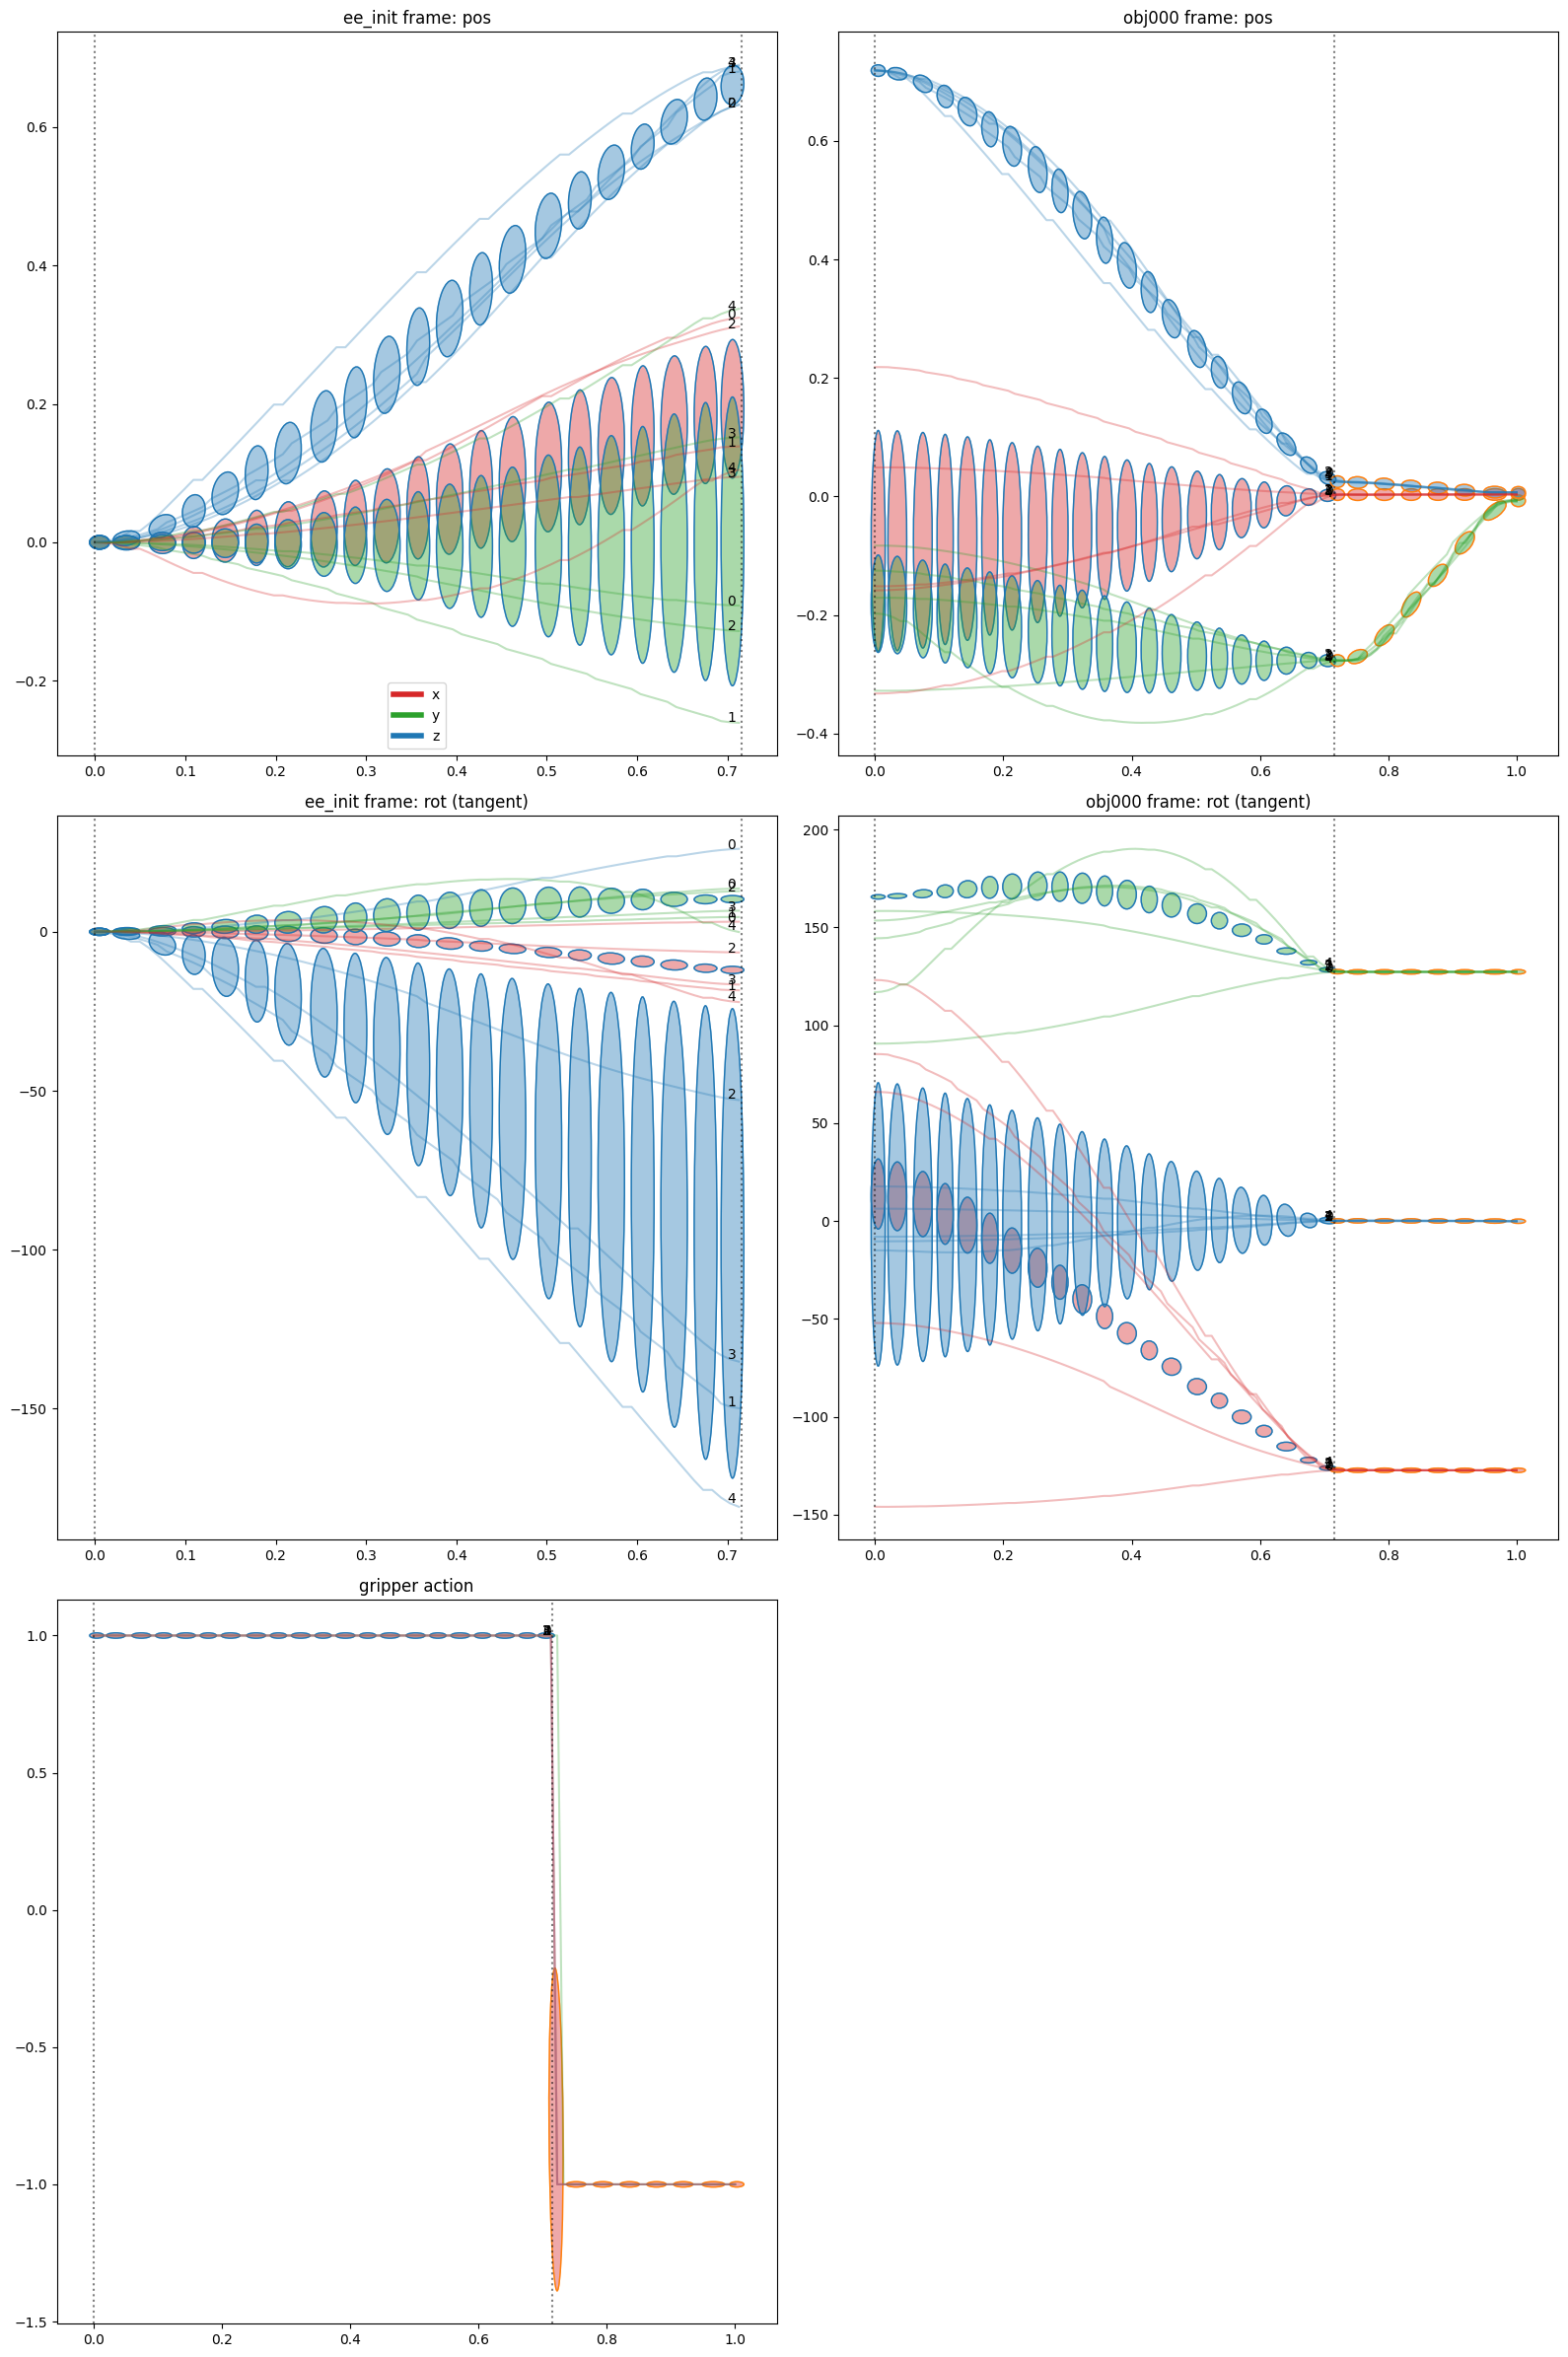

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2024-08-14 13:16:08.167 | INFO     |  Fitting AutoTPGMM
2024-08-14 13:16:08.167 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-14 13:16:08.172 | INFO     |  HMM EM ...
2024-08-14 13:16:08.180 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-14 13:16:08.377 | INFO     |  HMM init priors not defined, initializing to uniform
2024-08-14 13:16:11.341 | WARNING  |  HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[0.97, 0.88, 0.54, ..., 0.  , 0.  , 0.  ],
         [0.03, 0.12, 0.46, ..., 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         ...,
         [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , ..., 0.06, 0.  , 0.  ],
         [0.  , 0.  , 0.  , ..., 0.94, 1.  , 1.  ]]),
  array([[0.28, 0.09, 0.02, ..., 0.  , 0.  , 0.  ],
         [0.72, 0.91, 0.98, ..., 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         ...,
         [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , ..., 0.39, 0.11, 0.03],
         [0.  , 0.  , 0.  , ..., 0.61, 0.89, 0.97]])),
 (2616.721277850489, 759.7721951789533))

2024-08-14 13:16:11.578 | INFO     |  Did not specify time_based, deciding automatically.


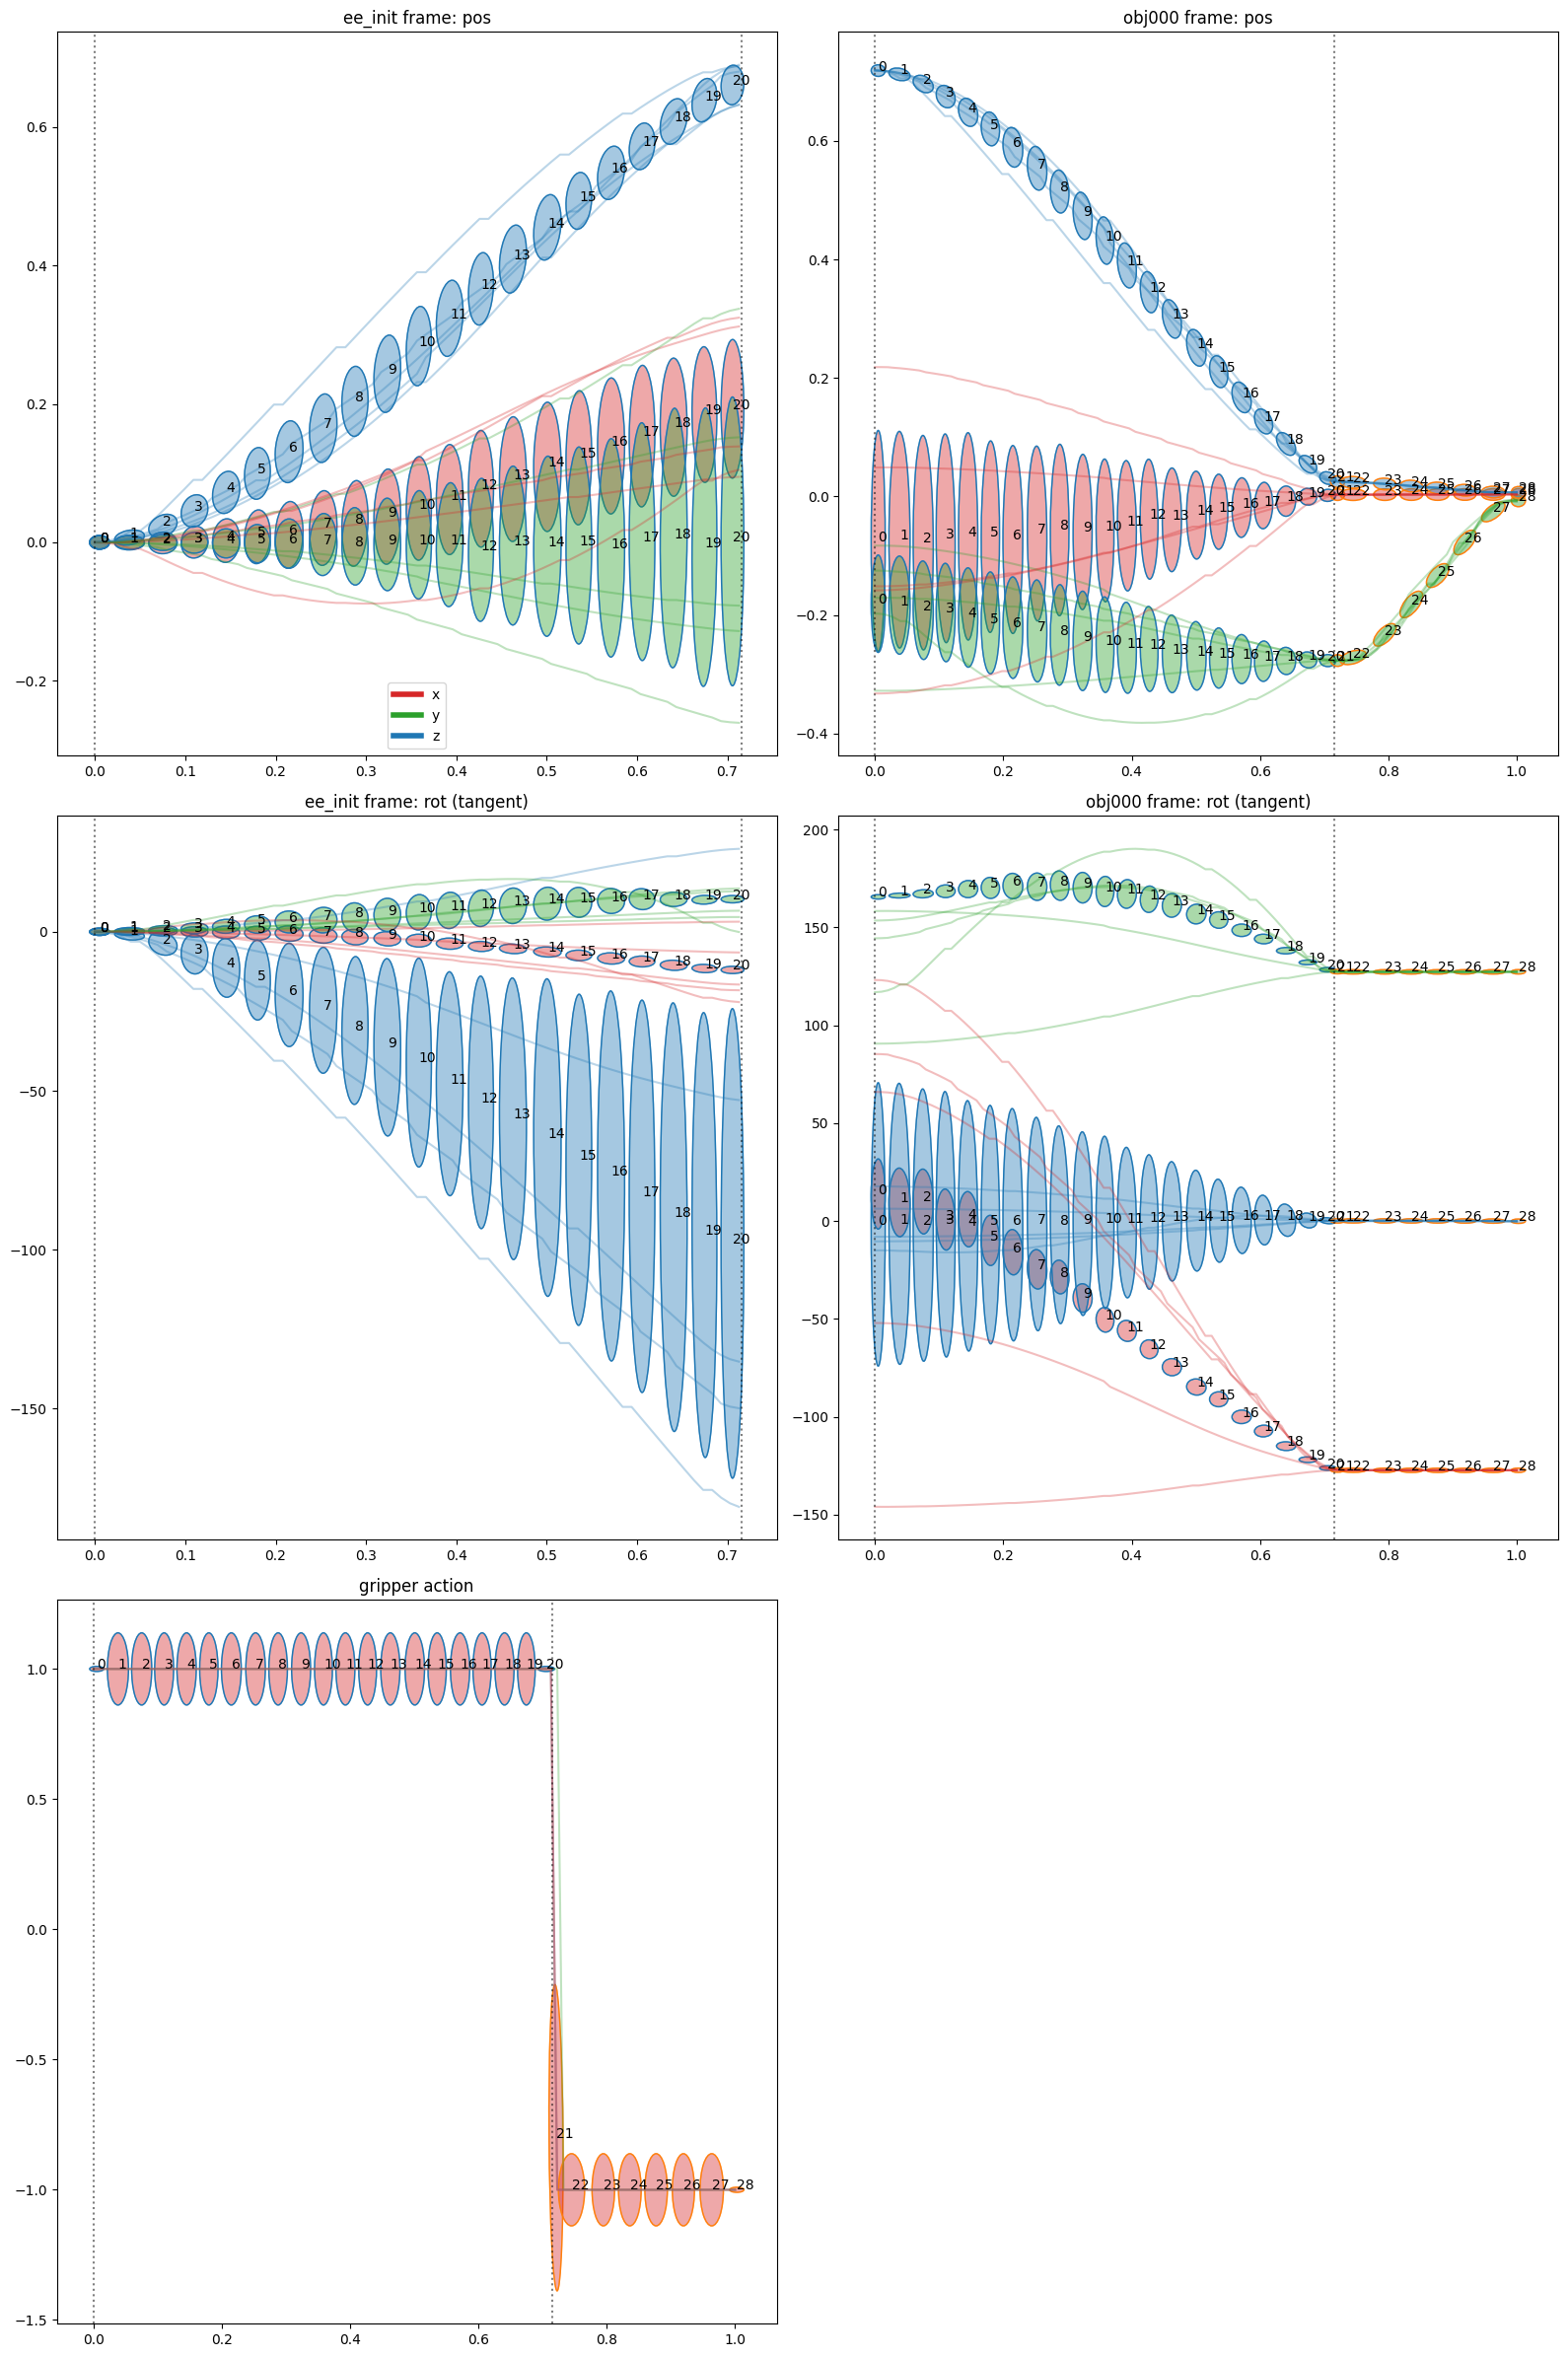

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

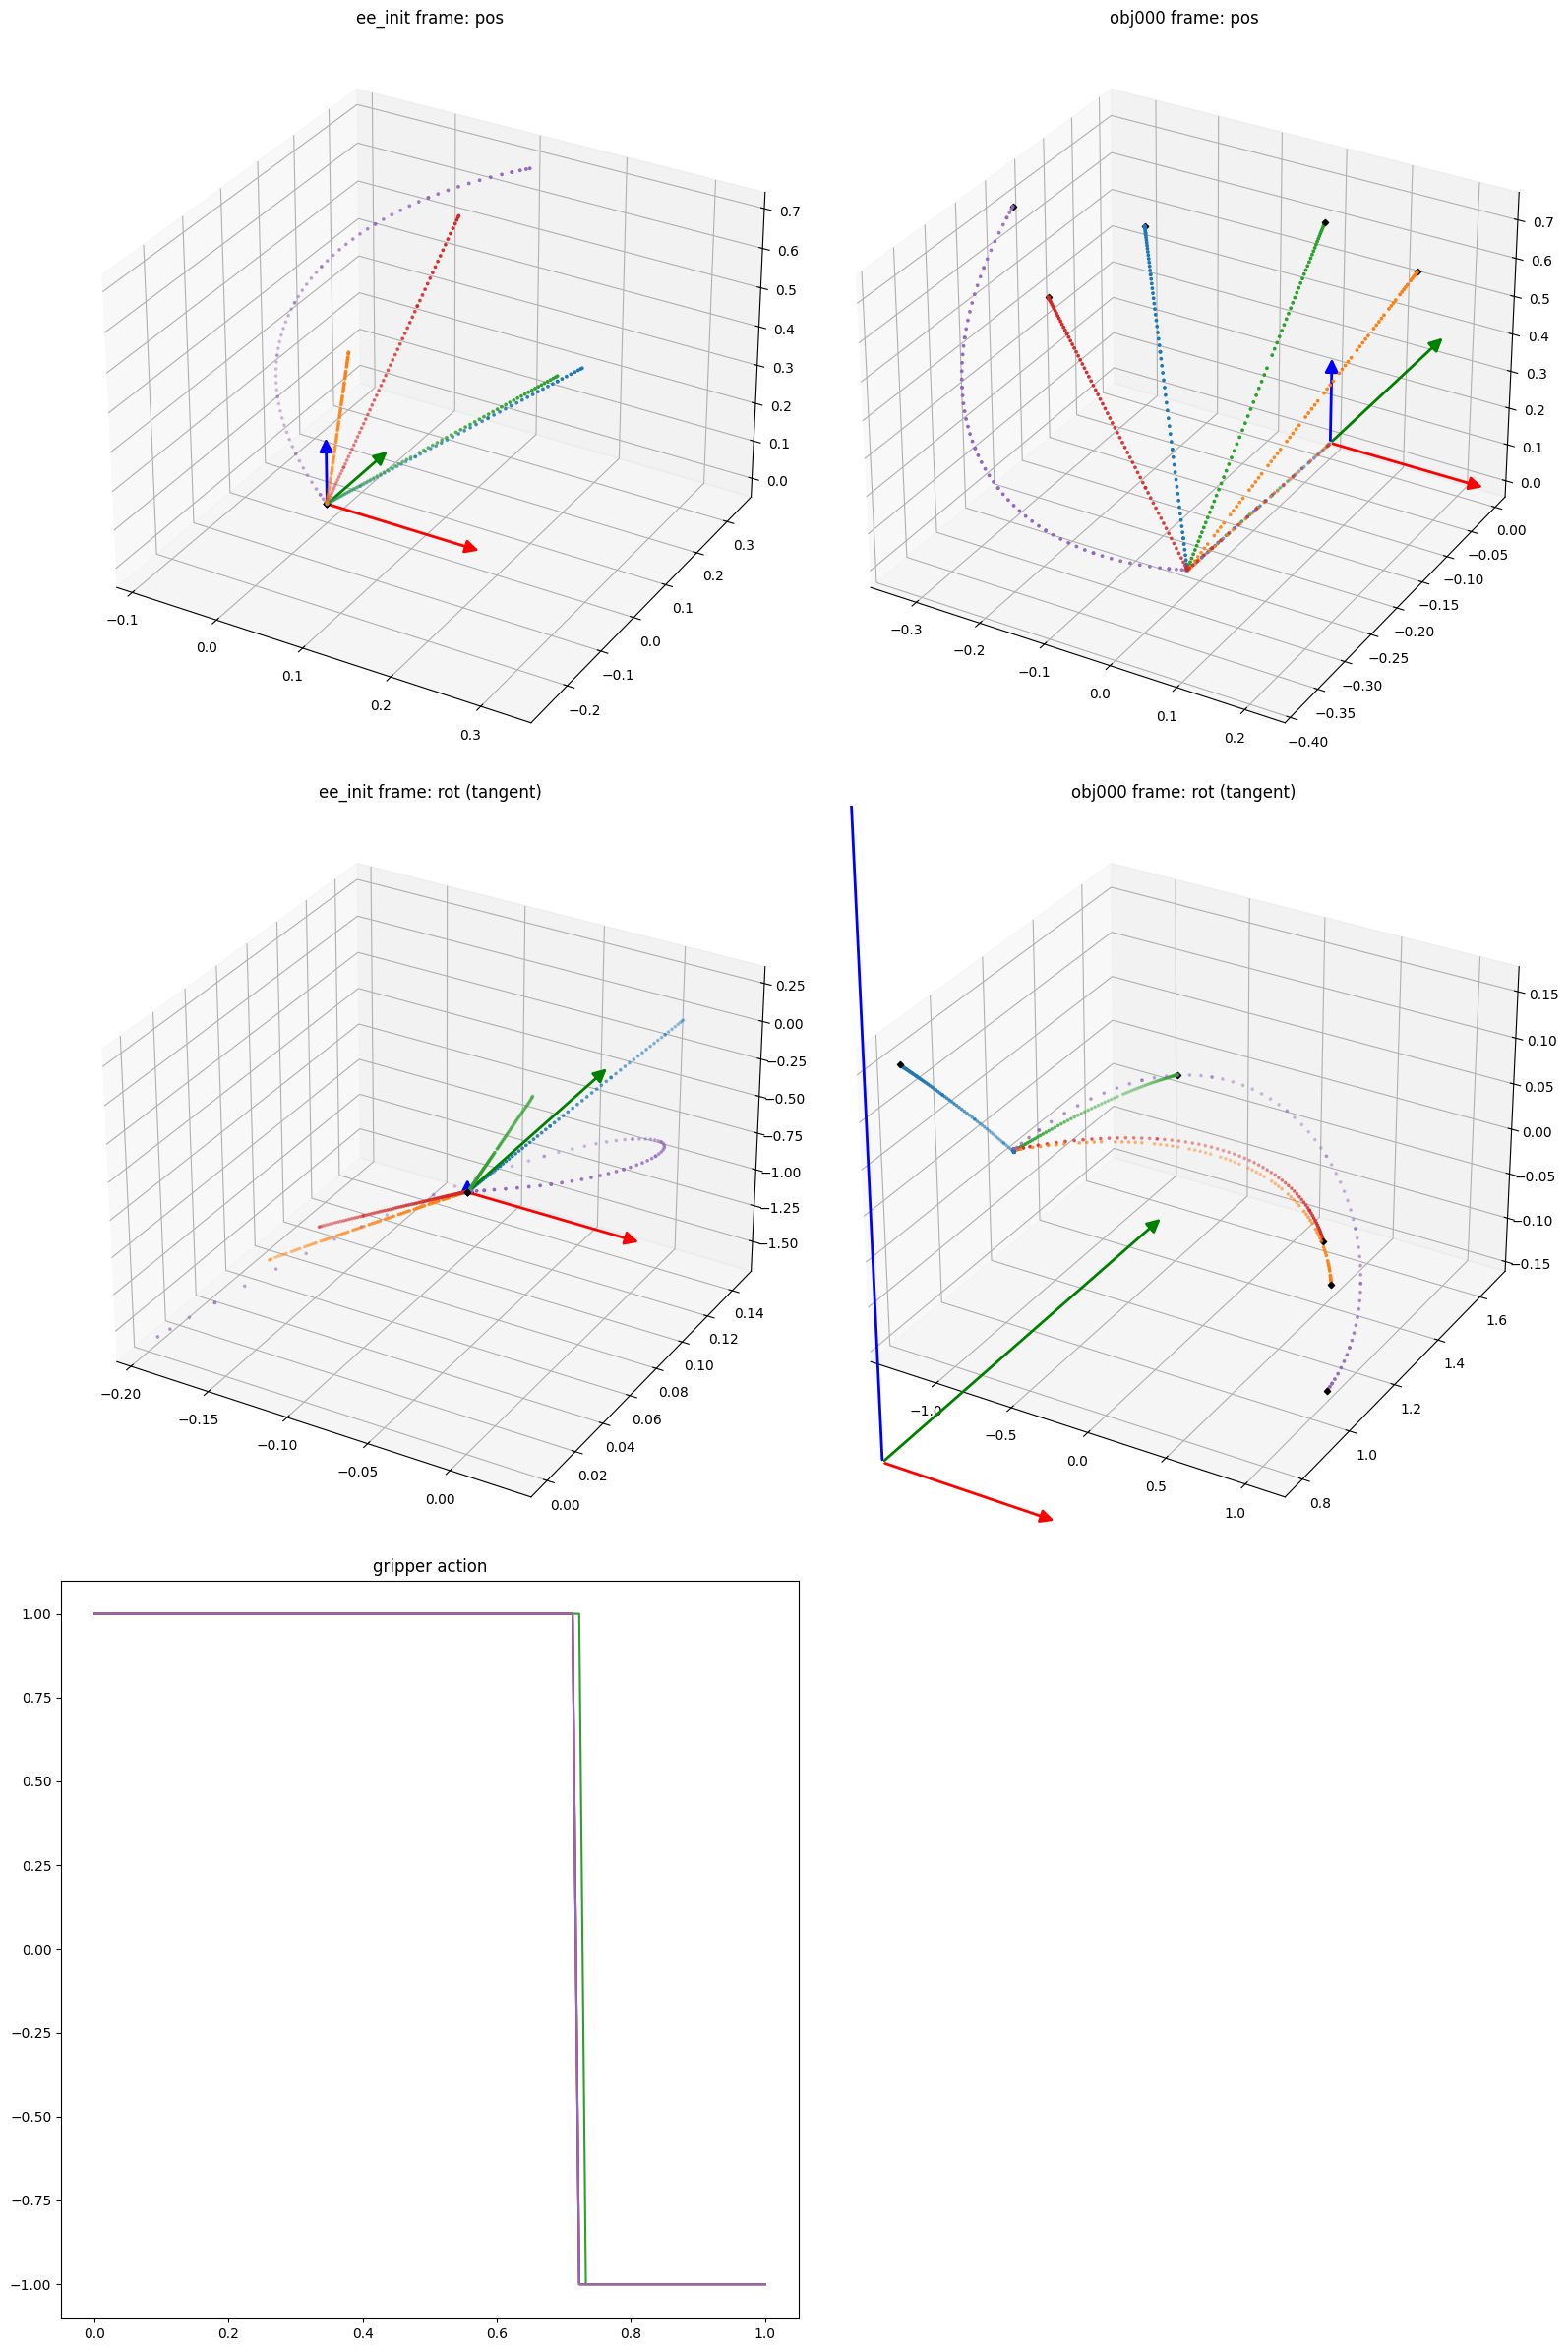

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

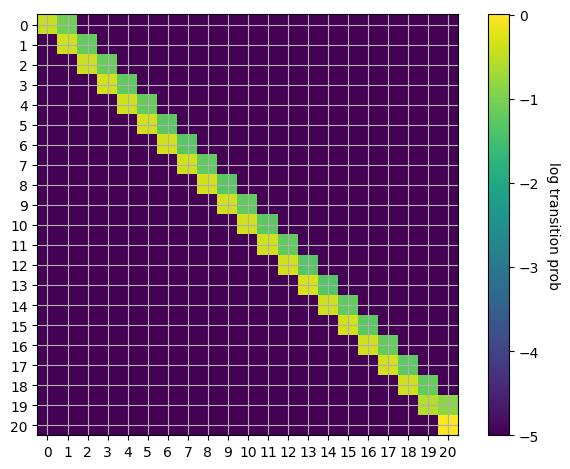

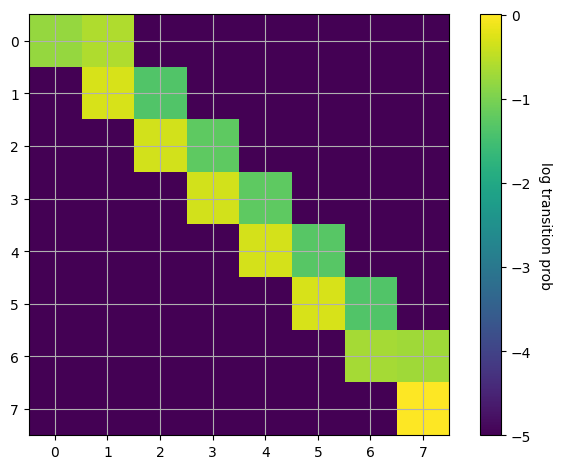

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2024-08-14 13:16:15.656 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2024-08-14 13:16:15.739 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2024-08-14 13:16:15.750 | INFO     |  Caculated segment transition probabilities: (array([[0.82]]),)
2024-08-14 13:16:15.750 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:16:15.829 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:16:16.015 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:16:16.041 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

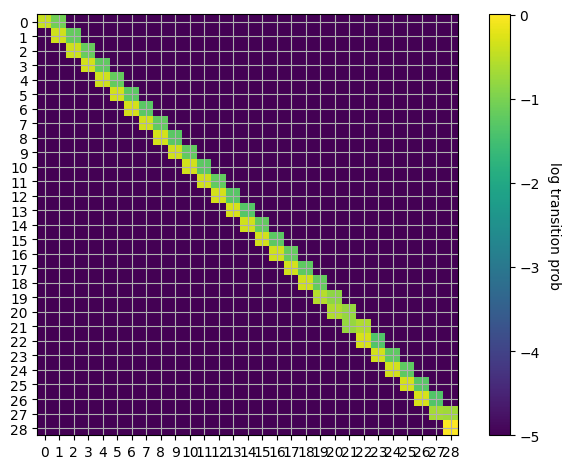

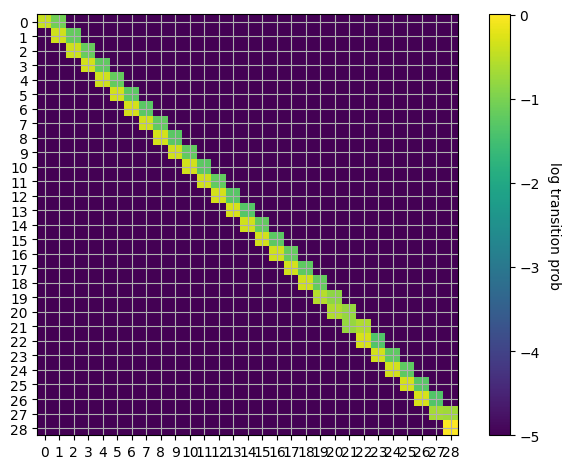

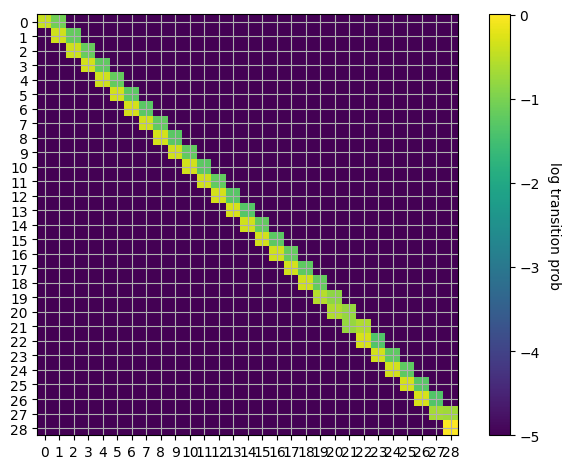

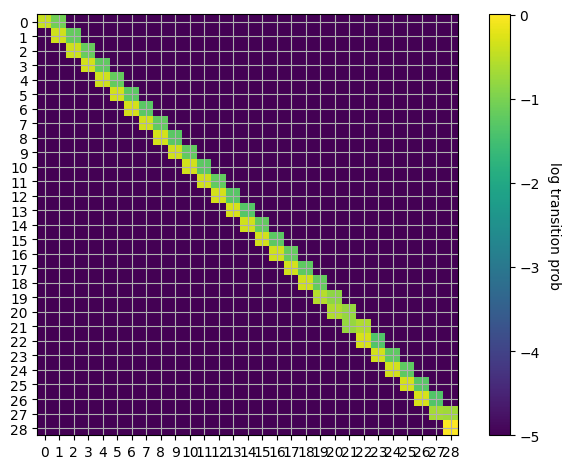

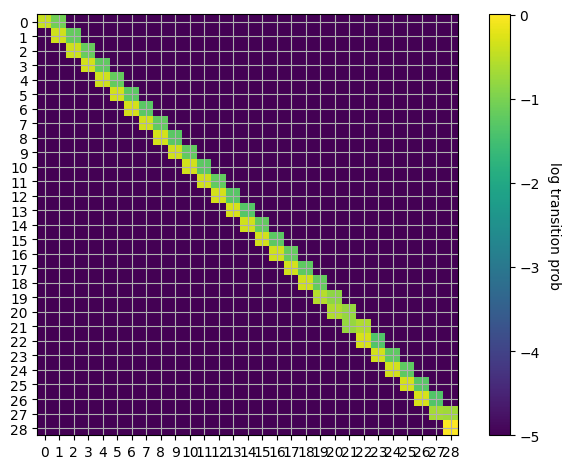

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2024-08-14 13:16:21.612 | INFO     |  Taking frame origins from demos.


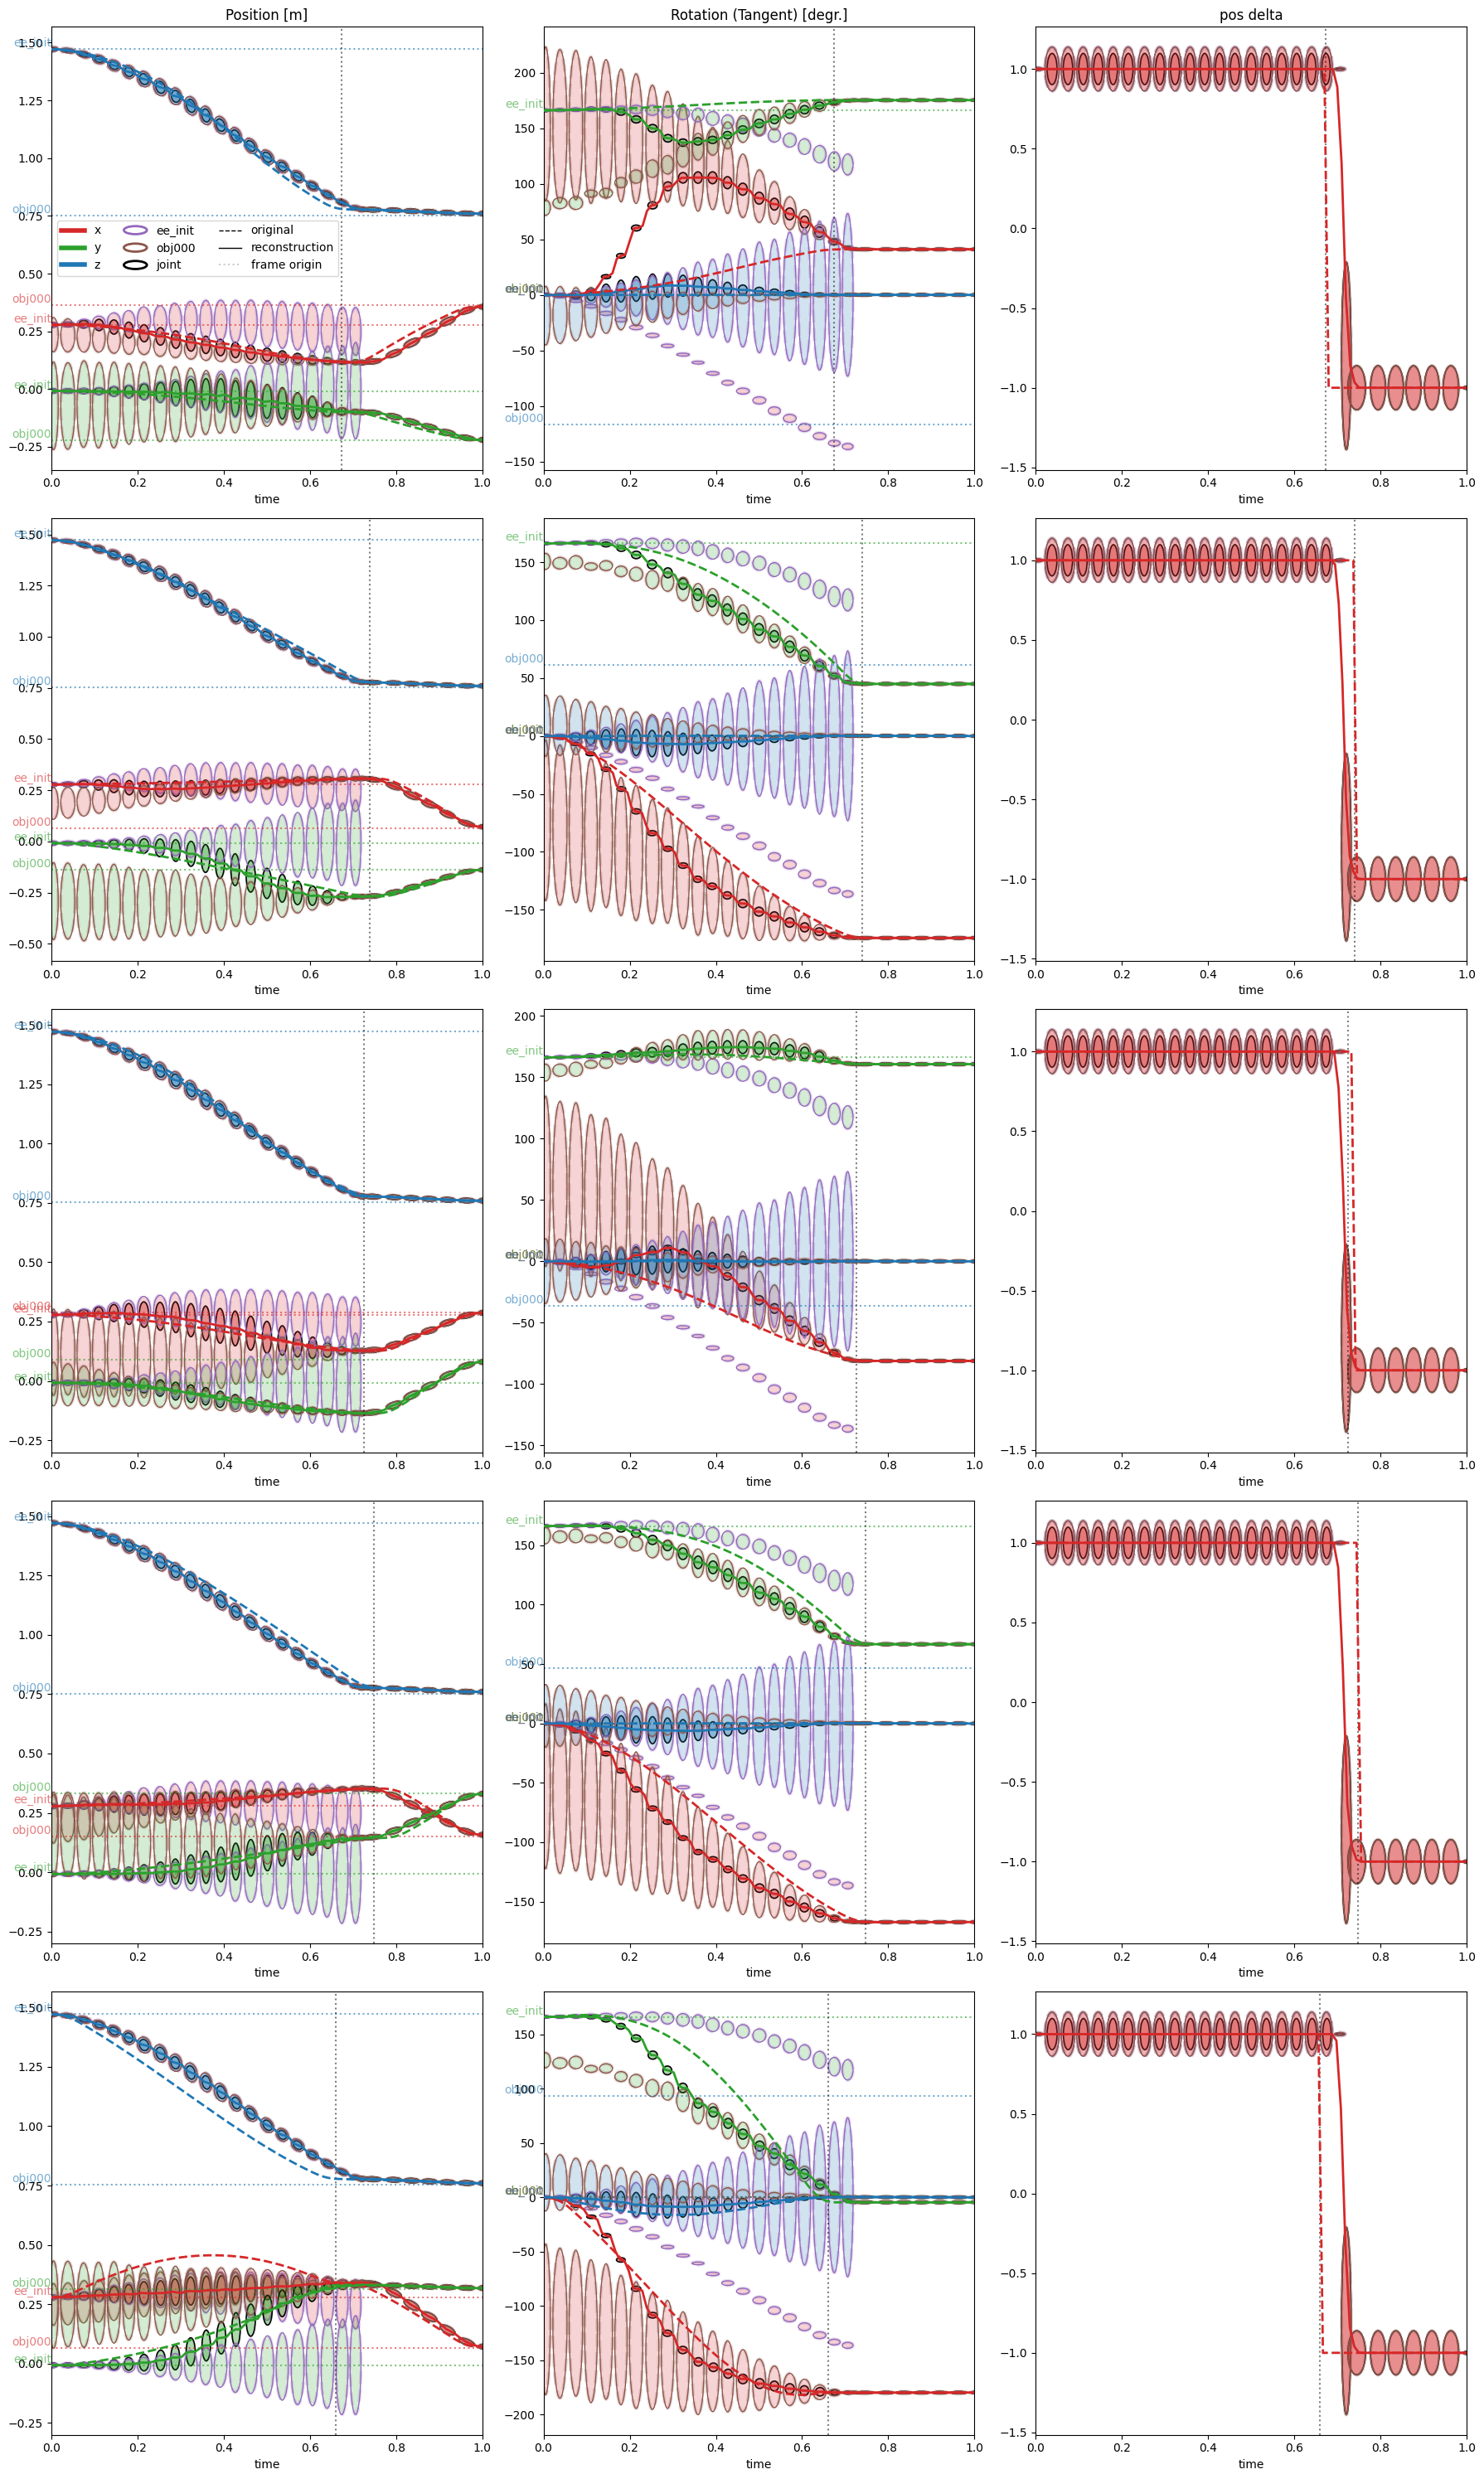

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


2024-08-14 13:16:48.052 | WARNING  |  Model uses moving frames. Can only plot one at a time. Plotting the one from the first time step.


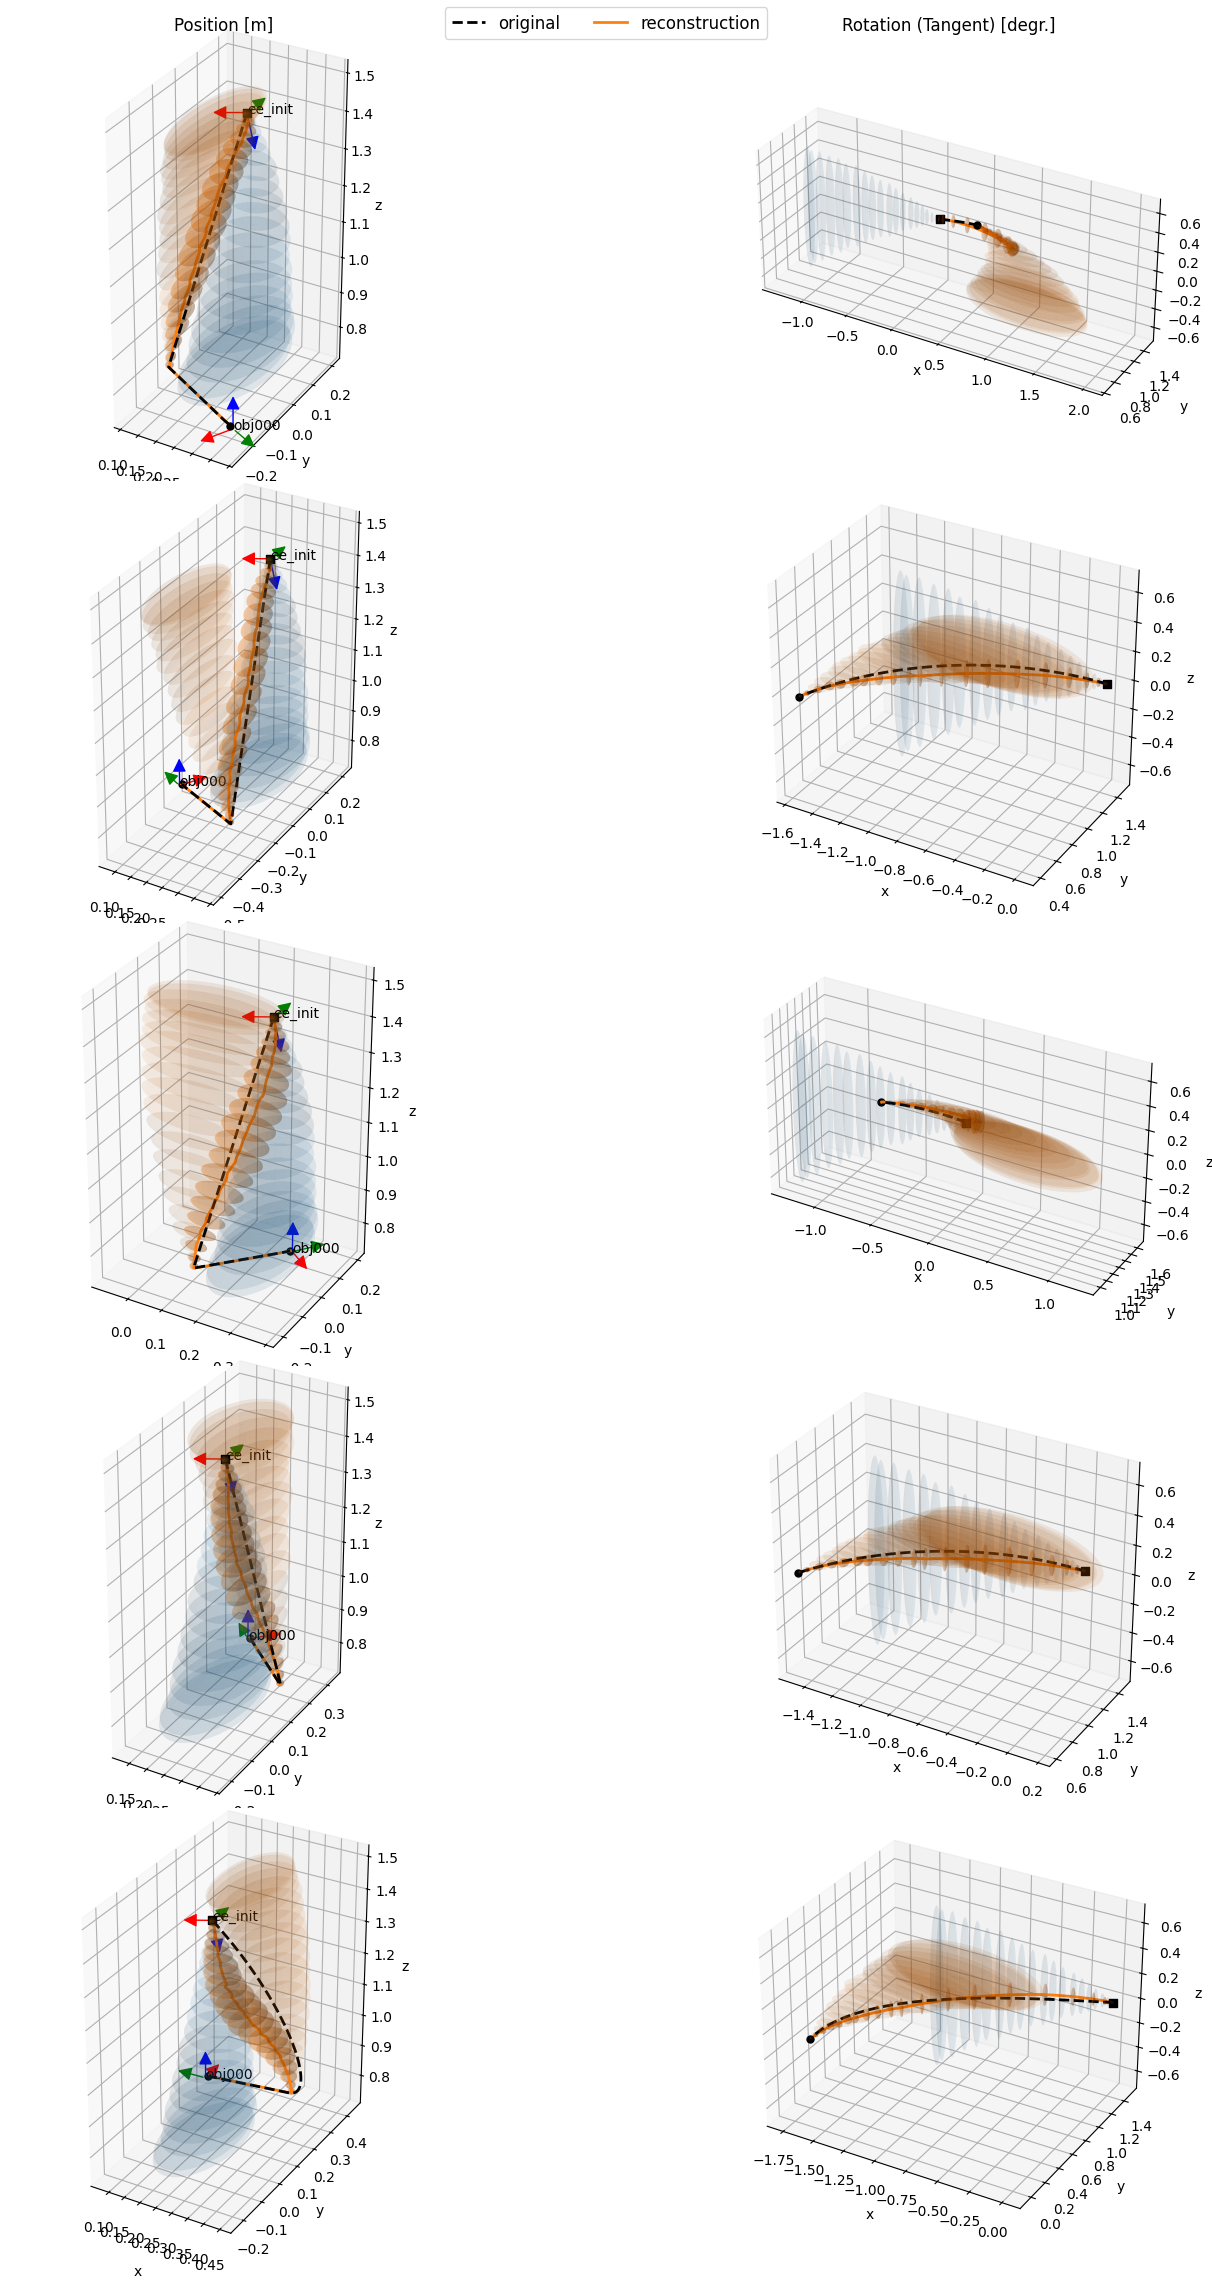

In [18]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)
